# Сравнение интегралов

Быстрое преобразование Фурье против метода Симпсона, на простом, но ключевом примере.

In [1]:
import numpy as np
from numpy import log, sqrt
from numpy import exp, linspace, fft, array, arange, pi
import matplotlib.pyplot as plt

In [2]:
# параметры модели для барьерного пута

T = 1
H_original = 90.0 # limit
K_original = 100.0 # strike
r_premia = 10 # annual interest rate
r = log(r_premia/100 + 1)
V0 = 0.316227766

delta_t = 1/100
r_premia = 10 # annual interest rate
r = log(r_premia/100 + 1)
q = 1.0/delta_t + r

sigma = V0
gamma = r - 0.5 * sigma**2 # Black-Scholes parameter, from a no-arbitrage condition

def psi(xi):
    return (sigma**2/2) * xi * xi - 1j*gamma*xi

omega_plus = 1



# Фи-минус

Мы считаем интегралы для того, чтобы получить приближённые выражения для факторов. Они вычисляются похожим способом, рассмотрим для примера $\phi^-_q(\xi)$. Их вид будет следующим:

$$ \phi^-_q(\xi) = exp[-i\xi F^-(0) - \xi^2 \hat{F}^-(\xi)] $$$$ F^-(x) = 1_{[0,+\infty)}(x)(2\pi)^{-1} \int_{-\infty + i\omega_+}^{+\infty + i\omega_+} e^{ix\eta} \frac{ln(q+\psi(\eta))}{\eta^2} d\eta =$$

$$// \upsilon = \eta -i\omega_+ //$$$$= 1_{[0,+\infty)}(x)(2\pi)^{-1} \int_{-\infty}^{+\infty} e^{ix(\upsilon+i\omega_+)} \frac{ln(q+\psi(\upsilon+i\omega_+))}{(\upsilon+i\omega_+)^2} d(\upsilon) = $$

$$= 1_{[0,+\infty)}(x)e^{-x\omega_+}\frac{1}{2\pi} \int_{-\infty}^{+\infty} e^{ix(\upsilon)} \frac{ln(q+\psi(\upsilon+i\omega_+))}{(\upsilon+i\omega_+)^2} d(\upsilon) $$

$$ \hat{F}^-(\xi) = \int_{-\infty}^{+\infty} e^{-ix\xi} F^-(x) dx $$

Вычислим значение подынтегральной части сразу в виде массива: $$intfunc(\upsilon) = \frac{ln(q+\psi(\upsilon+i\omega_+))}{(\upsilon+i\omega_+)^2}, \upsilon \in \upsilon\_space$$


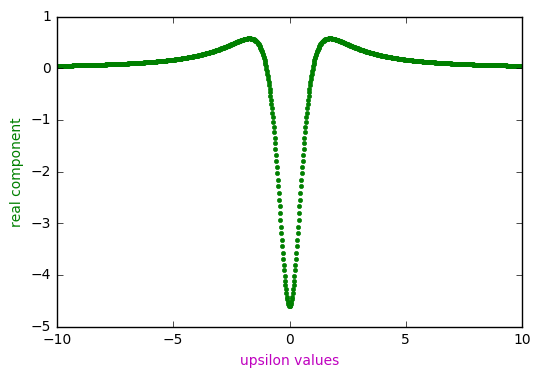

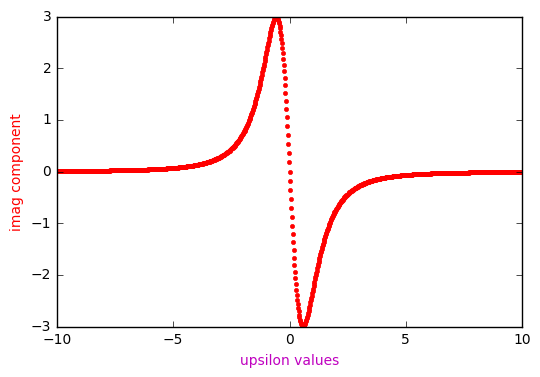

In [3]:
def integrand_minus(upsilon_array):
    """
    принимает и возвращает массив длиной в степень двойки, исходя из логики дальнейшего использования
    """
    return np.array([log(q + psi(upsilon + 1j*omega_plus)) / (upsilon + 1j*omega_plus)**2 for upsilon in upsilon_array])

upsilon_M = 2**10
upsilon_space = np.linspace(-10.0, 10.0, num=upsilon_M, endpoint=False)

plt.plot(upsilon_space, integrand_minus(upsilon_space).real, 'g.')
plt.xlabel('upsilon values', color='m')
plt.ylabel('real component', color='g')

plt.show()

plt.plot(upsilon_space, integrand_minus(upsilon_space).imag, 'r.')


plt.xlabel('upsilon values', color='m')
plt.ylabel('imag component', color='r')

plt.show()

$$F^-(\color{orange}{x}) = 1_{[0,+\infty)}(x)e^{-x\omega_+} \color{orange}{\frac{1}{2\pi}\int_{-\infty}^{+\infty} e^{i\color{orange}{x}(\color{magenta}{\upsilon})} intfunc(\color{magenta}{\upsilon}) d(\color{magenta}{\upsilon})} $$

Множитель $1_{[0,+\infty)}(x)e^{-x\omega_+}$ помогает подавить некоторые нежелательные эффекты (хотя и затуманивает их) и уйти от разреза логарифма.

Часть, которая имеет отношение к преобразованию Фурье, выглядит вот так:

$$F^-(\color{orange}{x}) = \color{orange}{\frac{1}{2\pi}\int_{-\infty}^{+\infty} e^{i\color{orange}{x}(\color{magenta}{\upsilon})} intfunc(\color{magenta}{\upsilon}) d(\color{magenta}{\upsilon})} $$

Здесь возникает проблема, связанная с реализацией fft. Умножению на $e^{ix\xi}$ соответствует в numerical recipes прямое преобразование Фурье и соответствующее DFT. У нас же в определениях - обратное. В библиотеке numpy придерживаются нашего подхода (вот документация, которая это подтверждает https://docs.scipy.org/doc/numpy/reference/routines.fft.html)

Тогда $\color{magenta}{\upsilon}$, в которых вычисляется наша подынтегральная функция, будет относиться к домену частот. И возьмёт на себя роль, которую берёт $\color{magenta}{\xi}$

На вход нужно передать массив $\color{magenta}{intfunc(\upsilon)}$

Точки, в которых он будет расчитан, также подбираются не случайно, о чём пойдёт речь дальше.

Напишем небольшой калькулятор для параметров преобразования Фурье, которые дают "подходящую" сетку разбиения.

Заметим для этого, что мы пользуемся предположением о "стандартном библиотечном" методе наполнения носителей, то есть

$$x_k = k\cdot dx, k = 0,1, ... ,M-1$$
$$\xi_k = \frac{l}{Mdx}, l = -M/2,-M/2+1, ... ,-1,0,1, ... ,M/2$$

То есть для $\xi_k$ используется частота в герцах. Для того, чтобы простые формулы для показателя экспонены (важные для fft) сохраняли силу, $\xi_k$ хранится "хитро" - сначала по возрастанию положительных частот, потом по возрастанию от "самой отрицательной" к нулю.

Для того, чтобы пользоваться прямым и обратным преобразованием Фурье с целью вычисления интегралов, нужно представлять, какие именно значения подынтегральной функции при этом получаются на входе и выходе преобразований.

В частности, для нашей задачи нужно понимать, насколько "частой" получается сетка и иметь возможность регулировать её ширину.

Разумным для человеческого восприятия представляется получать величину ячейки сетки в виде $dx = 1 \cdot 10^{-p}$ и $d\xi = 1 \cdot 10^{-q}$. (альтернатива с основанием 2 ведёт к более красивой форме связи, но плохо воспринимается на вид)

Интересным представляется следующий вопрос - как связаны между собой $dx$ и $d\xi$? Как, задавая одну сетку, не получить другую "слишком частой", чтобы не упустить важные особенности рассматриваемой функции?

Для того, чтобы fft работало, нужно, чтобы $ M = 2^N, N \in \mathcal{N}$.
Это $N$ играет роль управляемого параметра и позволяет получить
$$x_k = k\cdot dx, k = 0,1, ... ,M-1$$

Посмотрев на выражение для $\xi_k$ выше, можно видеть, что $d\xi = \xi_1 -  \xi_0 = \frac{1}{Mdx}$

Отсюда вытекает соотношение $\frac{1}{dx} = Md\xi$ или $dx = \frac{1}{M d\xi}$

Это сравнительно плохая новость, потому что уменьшение одного разбиения за счёт этой связи приводит к "раздутию" другого (что очевидно, учитывая физическую интерпретацию величин, но оттого не менее безрадостно). Единственный способ "задавить" этот рост состоит в увеличении N, связанном с этим возрастанием M и неизбежным при такой постановке увеличением области интегрирования (и ошибок округления, конечно). Тем не менее, $dx = \frac{1}{2^N d\xi}$ и $d\xi = \frac{1}{Mdx}$

Зададимся, например, вопросом, который возникает при применении обратного преобразования Фурье.

Например, у меня нас фиксированная сетка $d\xi = 1 \cdot 10^{-q}$, которую мы находим приемлемой для интегрирования. Известно, что после применения ifft мы получим функцию от переменной x, определённую в точках $x_k = k\cdot dx, k = 0,1, ... ,M-1$ (и не в других, потому что другие требуют другого представления для $\xi$). Может оказаться, что нам нужно, чтобы в этих точках такая выходная функция также должна быть определена на достаточно густой сетке (то есть $dx \le 1 \cdot 10^{-p})$. Сосредоточимся на случае, когда нужно, чтобы $dx = 1 \cdot 10^{-p})$. Найдём значение N, которое позволяет это сделать.

Для этого рассмотрим соотношение $dx = \frac{1}{M d\xi}$ и подставим нужное:

$10^{-p} = \frac{1}{2^N 10^{-q}}$

$10^{-(p+q)} = \frac{1}{2^N}$

$10^{-(p+q)} = 2^{-N}$

$\lg(10^{-(p+q)}) = \lg(2^{-N})$

$-(p+q) = -N\lg(2)$

$p+q = N\lg(2)$

$N = \frac{p+q}{\lg(2)}$

$N = (p+q)\log_{2}{10}$

Десятичным логарифмом пользоваться может быть не всегда удобно, поэтому можно и так:

$N = (p+q) \frac{\ln(10)}{\ln(2)}$


В частном случае, если $p=q$, формула принимает удобный вид

$N = q\cdot2\log_{2}{10}$

Учитывая, что N должно быть целым, вариантов для точного соответсвия найдётся немного. Тем не менее, если цель состоит в том, чтобы иметь сетку "не хуже", чем нужная - нас вполне устроит ближайшее целое N "сверху"

Немного более неудобно дело может обстоять дело в том случае, если мы используем обратное преобразование Фурье, определённое в терминах угловой (циклической) частоты, то есть
$ f(x) = \int_{-\infty}^{infty} e^{i\xi x} \hat{f}(\xi) d\xi$, вместо $ f(x) = \int_{-\infty}^{infty} e^{2\pi*i\xi x} \hat{f}(\xi) d\xi$.

В дискретном случае, для того, чтобы получить "простую" сумму $ f(x_k) = d\xi \cdot \sum_{l = 0}^{M} e^{2\pi ikl/M} \hat{f}(\xi_l)$ используется представление $$\xi_k = \frac{l}{Mdx}, l = -M/2,-M/2+1, ... ,-1,0,1, ... ,M/2$$ - в терминах частоты в Герцах.

Поэтому множитель в $2\pi$ должен появиться при $x_k := 2\pi \cdot k dx, k = 0,1, ... ,M-1$

Это вносит довольно эффект в поведение сетки для $x_k$ и "растягивает" её сильнее.

Для того, чтобы получить "растянутую" сетку с нужной точностью, нам можно использовать другую оценку для N.

Действительно, теперь $h_\pi := 2\pi dx$, то есть $dx = \frac{h_\pi}{2\pi}$

Рассмотрим соотношение $dx = \frac{1}{M d\xi}$:

$\frac{h_\pi}{2\pi} = \frac{1}{M d\xi}$ 

$h_\pi = \frac{2\pi}{M d\xi}$ 

Используем представление из рассмотренного ранее примера ($h_\pi = 1 \cdot 10^{-p}$ и $d\xi = 1 \cdot 10^{-q}$):

$10^{-p} = \frac{2\pi}{2^N 10^{-q}}$

$10^{-(p+q)} = \frac{2\pi}{2^N}$

$10^{-(p+q)} = 2\pi 2^{-N}$

Логарифмируем и перетащим оцениваемый параметр влево:

$log_2(2\pi \cdot 2^{-N}) = \log_2(10^{-(p+q)})$

$log_2(2\pi) + log_2(2^{-N}) = -(p+q)\log_2(10)$

$log_2(2^{-N}) = -(p+q)\log_2(10) - log_2(2\pi)$

$- N = -(p+q)\log_2(10) - log_2(2\pi)$

$N = (p+q)\log_2(10) + 1 + log_2(\pi)$

В частном случае, если $p=q$, формула принимает вид

$N = q\cdot2\log_{2}{10} + 1 + log_2(\pi)$

И это увеличивает степень двойки не менее чем на 3 по сравнению с предыдущей калькуляцией. Это существенно.

In [108]:
from numpy import log2, ceil

#этот метод - для "расширенного" x

# имеющаяся ширина ячейки сетки для \xi
# q определяет степень десятки (и количество знаков после запятой) для \xi
q = 3
du = 10**(-q)
# p определяет степень десятки (и количество знаков после запятой) для \x, увеличенного в 2pi
p = 3
dx = 10**(-p)

N = (p+q)*log2(10) + 1 + log2(pi)
print("Имеется сетка по u шириной", du, ", подбираем по растянутому x не реже", dx)
print("Точный ответ", N, ", ближайшее целое N:", ceil(N))

print("Диапазоны изменений при этом следующие", dx)

Имеется сетка по u шириной 0.001 , подбираем по растянутому x не реже 0.001
Точный ответ 22.5830646988 , ближайшее целое N: 23.0
Диапазоны изменений при этом следующие 0.001


# Вычисление с использованием iFFT

$$F^-(\color{orange}{x}) = 1_{[0,+\infty)}(x)e^{-x\omega_+} \color{orange}{\frac{1}{2\pi}\int_{-\infty}^{+\infty} e^{i\color{orange}{x}(\color{magenta}{\upsilon})} intfunc(\color{magenta}{\upsilon}) d(\color{magenta}{\upsilon})} $$

Проведём эксперимент. Зададим точно ширину ячейки по $\xi$, отрегулируем при помощи калькулятора выше ячейку для x и выведем всё, что получилось.

Используем "растянутую" версию, $x_k = 2\pi hk$

In [115]:
M = 2**23
du = 0.001
dx = 2*pi/ (M * du)
u_space_pos = np.array([l*du for l in range(M//2)])
u_space_neg = np.array([-(M//2 * du) + l*du for l in range(M//2)])
u_space = np.concatenate((u_space_pos, u_space_neg))

x_space = np.array([k*dx for k in range(M)])
# plt.plot(x_space, 'y', u_space, 'm')
# plt.show()

print("В вычислениях будет использовано всего", M, "точек")
print("du = ", du, "Частота меняется от ", u_space[M//2], "до", u_space[M//2 - 1])

print("dx = ", dx, "Пространственная переменная меняется от ", x_space[0], "до", x_space[M-1])

print("Омега плюс равна", omega_plus)

В вычислениях будет использовано всего 8388608 точек
du =  0.001 Частота меняется от  -4194.304 до 4194.303
dx =  0.0007490140565847857 Пространственная переменная меняется от  0.0 до 6283.18455817
Омега плюс равна 1


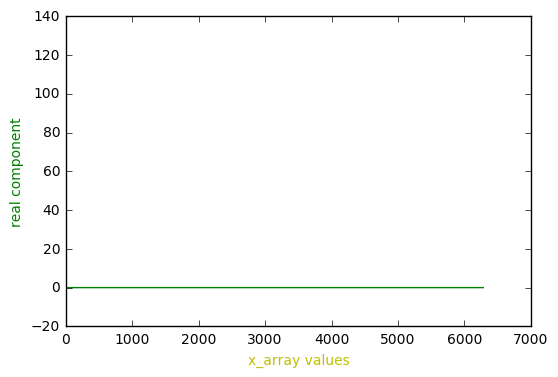

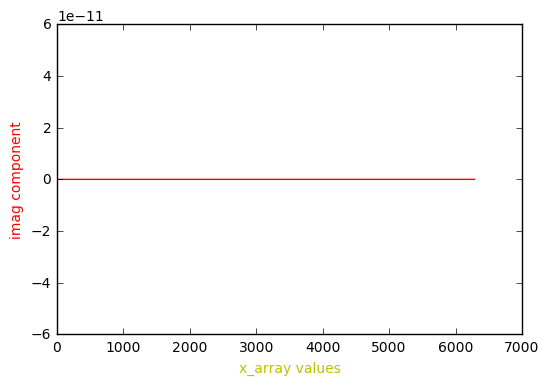

In [116]:
# куда девается индикатор? У нас просто нет ни одной точки, где x было бы отрицательным, в этой постановке. 
# Появится - допишу, примеров есть много уже, благо.

def F_minus_capital():
    big_integral = fft.ifft(integrand_minus(u_space))
    exponent = exp(-x_space * omega_plus)
    return 1/(2*pi) * M * big_integral * exponent

fm = F_minus_capital()


# создавать лог происходящего очень полезно, потому что не всегда можно полагаться на авторисователь. 
# Но выходной файл занимает довольно велик (для 2^23 там 260 мб), даже если включать только действительную часть.
# np.savetxt('fft_out.txt', fm.real)
           
# plt.plot(x_space, fm.real, 'g')
# plt.xlabel('x_array values', color='y')
# plt.ylabel('real component', color='g')
# plt.show()

# plt.plot(x_space, fm.imag, 'r')
# plt.xlabel('x_array values', color='y')

# plt.ylabel('imag component', color='r')
# plt.show()

Визуализация таких огромных массивов данных - сложная задача. Отрисуем только значимую часть, где значения ещё не слишком малы. Многочисленные опыты с мнимой частью показывают, что она мала везде (порядка 1e-11 максимум, даже если "давящий множитель" не использовать), поэтому её визуализацию я не использую умышленно.

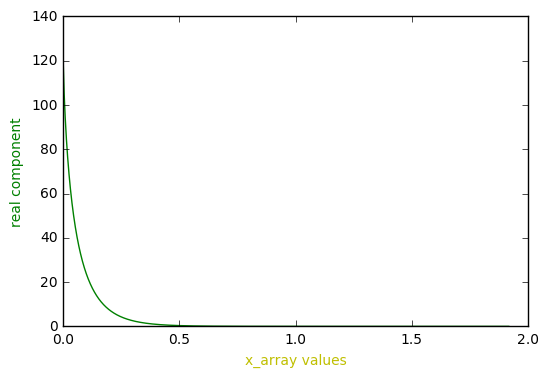

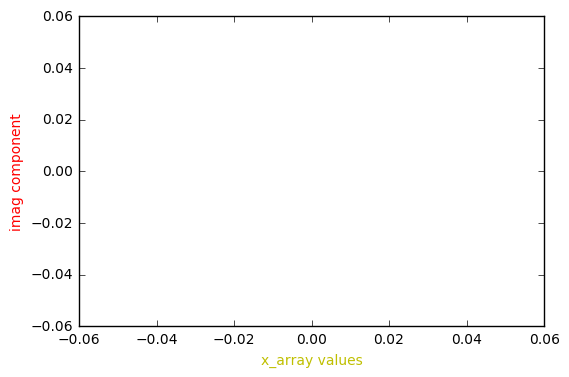

In [118]:
filter_for_drawing = np.where(fm.real > 1e-6, 1, np.nan)

plt.plot(x_space * filter_for_drawing, fm.real * filter_for_drawing, 'g')
plt.xlabel('x_array values', color='y')
plt.ylabel('real component', color='g')
plt.show()

# Тот же интеграл методом Симпсона: 

$$F^-(\color{orange}{x}) = 1_{[0,+\infty)}(x)e^{-x\omega_+} \color{orange}{\frac{1}{2\pi}\int_{-\infty}^{+\infty} e^{i\color{orange}{x}(\color{magenta}{\upsilon})} intfunc(\color{magenta}{\upsilon}) d(\color{magenta}{\upsilon})} $$


dx =  0.1
du =  0.0100010001


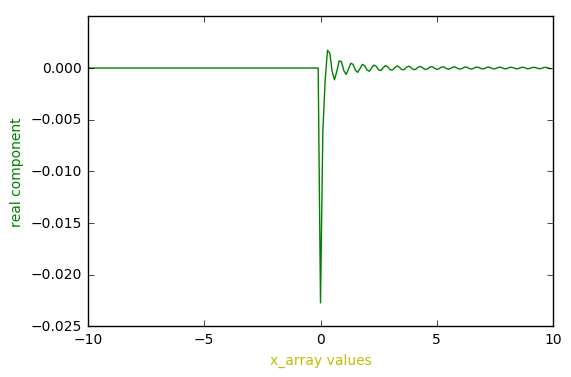

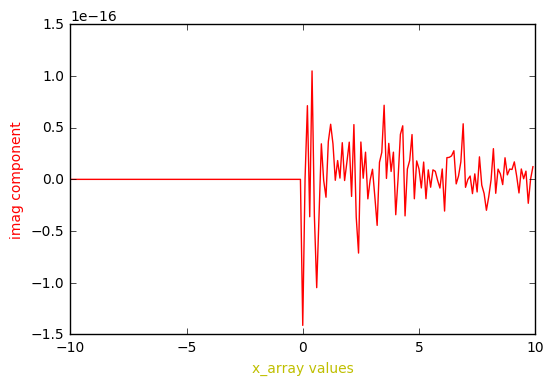

In [10]:
from scipy import integrate
sample_x_array = np.linspace(-10.0, 10.0, num=200, endpoint=False)
print("dx = ", sample_x_array[1] - sample_x_array[0])
upsilon_space = np.linspace(-50, 50, num = 10000, endpoint=True)
# upsilon_space = respective_upsilon_space

print("du = ", upsilon_space[1] - upsilon_space[0])
def F_minus_capital(x_point):
    if x_point < 0:
        return 0
    else:
        osc_exponent = np.array([exp(1j*x_point*upsilon_elem) for upsilon_elem in upsilon_space])
        integrand = integrand_minus(upsilon_space) * osc_exponent 
        big_integral = integrate.simps(integrand, upsilon_space)
        
        constant_exponent = exp(-sample_x_array * omega_plus)
        weighted_big_integral = 1.0/(2.0*pi) * constant_exponent * big_integral
        return weighted_big_integral

F_minus_capital_on_domain = np.array([F_minus_capital(x_point) for x_point in sample_x_array])
plt.plot(sample_x_array, F_minus_capital_on_domain.real, 'g')
plt.xlabel('x_array values', color='y')
plt.ylabel('real component', color='g')
plt.show()

plt.plot(sample_x_array, F_minus_capital_on_domain.imag, 'r')
plt.xlabel('x_array values', color='y')
plt.ylabel('imag component', color='r')
plt.show()